In [1]:
# Solving and simulating a baseline New Keynesian model adapted from Martin Ellison's Matlab code: 
# http://users.ox.ac.uk/~exet2581/recursive/recursive.html
# originally wrote in Julia 0.6.1.1 by Petre Caraiani
# revised in Julia 1.15
# this code is part of chapter 3, "Solving and Simulating DSGE Models" from the book: "Introduction to Quantitative Macroeconomics using Julia"
# Academic Press - Elsevier
# for comments, email at: petre(dot)caraiani(at)gmail(dot)com

using LinearAlgebra
#using Plots
#Calibrated parameter values
beta=0.99;
sigma=1.0;
chi=1.55;
eta=0;
theta=2.064;
omega=0.5;
alpha=3;
delta=1.5;
rho=0.5;

kappa=(1-omega)*(1-beta*omega)/(alpha*omega);

#Number of predetermined and jump variables
n=1;#predetermined variables
m=2;#jump variables
nu=1;

cutoff=1.0;

#Define state space matrices

A0=zeros(3,3);
A0[1,1]=1;
A0[2,2]=1;
A0[2,3]=sigma^-1;
A0[3,3]=beta;

A1=zeros(3,3);
A1[1,1]=rho;
A1[2,1]=sigma^-1;
A1[2,2]=1;
A1[2,3]=sigma^-1*delta;
A1[3,2]=-kappa;
A1[3,3]=1;

B0=zeros(3,1);
B0[1,1]=1;

#Calculate alternative state space matrices

A=inv(A0)*A1;
B=inv(A0)*B0;

lambda=eigvals(A);

println("lambda=");
println(transpose(real(lambda)));


lambda=
[0.5 1.09006734006734 1.09006734006734]


In [2]:
#Blanchard-Kahn Conditions

bk_n = 0;

for i = 1:length(lambda)
    if     abs.(lambda[i]) > 1.0
    bk_n = bk_n+1;   
    end      
end;


println("BK condition");
println("Number of jump variables:",m);
println("Number of unstable roots:",bk_n);

if bk_n==m;
    println("BK satisfied")
elseif bk_n>n
    println("Too many unstable roots")
else
    println("Too few unstable roots")
end;



BK condition
Number of jump variables:2
Number of unstable roots:2
BK satisfied


In [3]:
#Sort eigenvectors and eigenvalues
v,w = eigen(A)
r=[abs.(v) w']

for i = 1:(m+n)
    for j = i+1:(m+n)
        if  real(r[i,1])> real(r[j,1])
            tmp = r[i,:];
            r[i,:]=r[j,:];
            r[j,:]=tmp;
        elseif real(r[i,1])== real(r[j,1])
            if imag(r[i,1])> imag(r[j,1])
            tmp = r[i,:];
            r[i,:]=r[j,:];
            r[j,:]=tmp;   
            end;    
        end;
    end;     
end;

#r=sortrows(r, by=x->real(x[1]));

In [4]:
lam= r[:,1];
M=r[:,2:4]';

P=inv(M);
lam=diagm(lam);

#solutions
LAMBDA1=lam[1:n,1:n];
LAMBDA2=lam[(n+1):n+m,(n+1):n+m];

P11 = P[1:n,1:n];
P12 = P[1:n,(n+1):n+m];
P21 = P[(n+1):n+m,1:n];
P22 = P[(n+1):n+m,(n+1):n+m];

R=P*B;

#decision rules
C11=real(inv(P11-P12*inv(P22)*P21)*LAMBDA1*(P11-P12*inv(P22)*P21));
C12=real(inv(P11-P12*inv(P22)*P21)*R[1]);
C21=real(-inv(P22)*P21);
C21

2×1 Matrix{Float64}:
 -1.2000000000000002
 -0.4

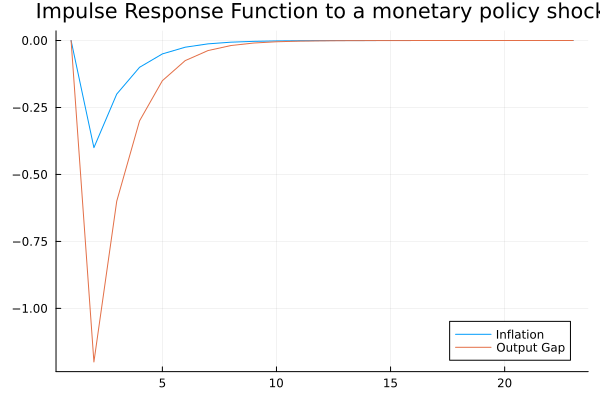

In [5]:
#IRF
horiz=24;
e=zeros(horiz,1);
x=zeros(horiz,2);
eps=zeros(horiz,1);
eps[1,1]=1;

for i = 1:horiz-1
e[i+1,:]=C11*e[i,1]+C12*eps[i,1]

x[i+1,:]=C21*e[i,1]
end;


#using Pkg
#Pkg.add("Plots")
using Plots

#pyplot()
#plotly() # Choose the Plotly.jl backend for web interactivity
plot(x[2:24,2],linewidth=1,label="Inflation",title="Impulse Response Function to a monetary policy shock")
plot!(x[2:24,1],linewidth=1,label="Output Gap")

In [14]:
#Simulation and moments
#variable names
name=['x',`pi`];
periods=500;
drop=250;
rep=100;
nlag=4;
nvars=size(name,1);
#matrices store results
stdst=zeros(rep,nvars);
corst=zeros(rep,nvars*nvars);
auto=zeros(rep,nvars*nlag);

In [15]:
using Statistics

In [16]:
for i = 1:rep
eps=sqrt(0.01)*rand(1,periods);   
x=zeros(periods,2);
e=zeros(periods,1);

#compute variables    
e[1,1]=0; 
x[1,:].=0;    
for j = 1:periods-1
e[j+1,:]=C11*e[j]+C12*eps[j]
x[j+1,:]=C21*e[j,1]
   
end
#drop burnins
stdst[i,1]=std(x[:,1])   
stdst[i,2]=std(x[:,2])       
end

#Display results
println("Simulation results");
println("Average standard deviation of output gap:",mean(stdst[:,1]));
println("Average standard deviation of inflation:",mean(stdst[:,2]));


Simulation results
Average standard deviation of output gap:0.04055598446200979
Average standard deviation of inflation:0.013518661487336596
